# Importing Libraries

In [ ]:
!pip -q install transformers

In [ ]:
import os
import re
import random
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
# BERT MODEL libraries
import torch
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading the dataset

In [ ]:
 # Load data and set labels
data = pd.read_csv('/content/suicidekenya7.csv', encoding= 'unicode_escape')
data.head()

,Text,Month2022,SuicideAttempts,Gender,AgeRange,Region,Reason,population,class
0,mimi nimechoka na hii dunia,January,1,male,45-54,central,jobless,6269579,suicide
1,I am going home,February,3,female,35-44,Rift-valley,none,12752966,non-suicide
2,bibi yangu ameniacha nitakunywa sumu,March,4,male,25-34,nyanza,love,6093172,suicide
3,I will kill my self,April,3,male,15-24,central,love,6269579,suicide
4,I am tired with this life,May,1,male,55-64,Nairobi,drugs,4397073,suicide


In [ ]:
data.rename(columns = {'class':'label'}, inplace = True)

In [ ]:
data = data[data.label.isin(['suicide', 'non-suicide'])]
data.label[data['label'] == 'suicide'] = 1
data.label[data['label'] == 'non-suicide'] = 0

In [ ]:
data.label.value_counts()

1    89
0    18
Name: label, dtype: int64

In [ ]:
data = data[['Text ', 'label']]

In [ ]:
data.head()

,Text,label
0,mimi nimechoka na hii dunia,1
1,I am going home,0
2,bibi yangu ameniacha nitakunywa sumu,1
3,I will kill my self,1
4,I am tired with this life,1


In [ ]:
data['label'] = data['label'].astype('int')

In [ ]:
data.dtypes

Text     object
label     int64
dtype: object

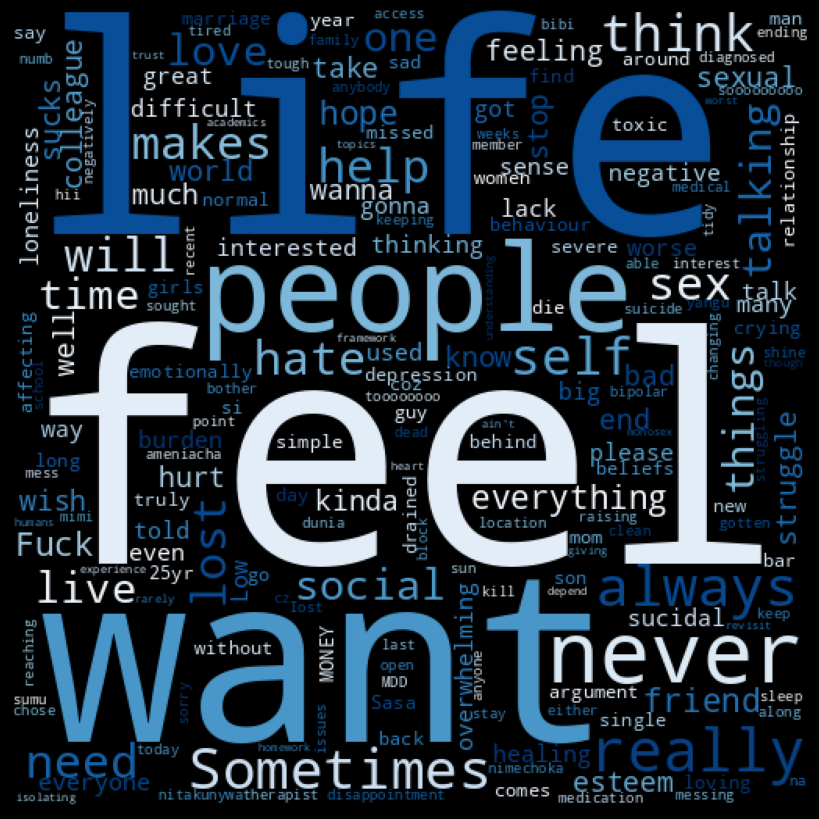

In [ ]:
#@title Default title text
suicide_words = ' '.join(list(data[data['label'] == 1]['Text ']))
suicide_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(suicide_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(suicide_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# Test Train Split

In [ ]:
X = data['Text ']
y = data['label']

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=20)

# Setting up GPU

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) are available.")
    print(f"Device Name {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available. We can use CPU instead")
    device = torch.device("cpu")

No GPU available. We can use CPU instead


# Data PreProcessing

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

## Fine tuning BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Finding max suitable length

In [ ]:
# Encode our  data
encoded_data = [tokenizer.encode(texts, add_special_tokens=True) for texts in  data['Text ']]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_data])
print('Max length: ', max_len)

Max length:  39


In [ ]:
#MAX_LEN = 40
# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[1]])[0].squeeze().numpy())
print('Original: ', X[1])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  I am going home
Token IDs:  [101, 1045, 2572, 2183, 2188, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Torch Data loader and Dataset for Training

In [ ]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train.to_numpy())

val_labels = torch.tensor(y_val.to_numpy())

In [ ]:


# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 4

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Classifier BERT Model

In [ ]:
%%time

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):

        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 68 µs, sys: 0 ns, total: 68 µs
Wall time: 73.9 µs


# HyperParameters

In [ ]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier

    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)

    return bert_classifier, optimizer, scheduler

# Setting Seed

In [ ]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

# Training

In [ ]:
def train(model, train_dataloader, val_dataloader=None, epochs=10, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy



In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=10)
train(bert_classifier, train_dataloader, val_dataloader, epochs=10, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.482283   |     -      |     -     |   55.02  
   1    |   23    |   0.623410   |     -      |     -     |   7.80   
----------------------------------------------------------------------
   1    |    -    |   0.499924   |  0.480715  |   80.56   |   64.70  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.334768   |     -      |     -     |   50.53  
   2    |   23    |   0.273999   |     -      |     -     |   8.16   
----------------------------------------------------------------------
   2    |    -    |   0.327172   |  0.517251  |   80.56   |   60.15  
----------------------------------------------------------------